In [1]:
from hydra import compose, initialize

with initialize(config_path="./clearaudio/conf", version_base="1.1"):
    cfg_yes_no = compose(config_name="config", overrides=["dataset=yes_no_dataset", "trainer=diffusion_local"])
    cfg_maestro = compose(config_name="config", overrides=["dataset=maestro_scitas_diffusion", "trainer=maestro_diffusion_local"])

In [2]:
# This code has been migrated to diffusers but can be run locally with
# pipe = DiffusionPipeline.from_pretrained("teticio/audio-diffusion-256", custom_pipeline="audio-diffusion/audiodiffusion/pipeline_audio_diffusion.py")

# Copyright 2022 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Credits to teticio/audio-diffusion
# https://github.com/teticio/audio-diffusion/blob/16d61b3612faaaca53bcacd02755d108b6aceb22/audiodiffusion/mel.py


from typing import Callable, Union

import numpy as np
import librosa
from PIL import Image


class Mel:
    """
    Parameters:
        x_res (`int`): x resolution of spectrogram (time)
        y_res (`int`): y resolution of spectrogram (frequency bins)
        sample_rate (`int`): sample rate of audio
        n_fft (`int`): number of Fast Fourier Transforms
        hop_length (`int`): hop length (a higher number is recommended for lower than 256 y_res)
        top_db (`int`): loudest in decibels
        n_iter (`int`): number of iterations for Griffin Linn mel inversion
    """

    def __init__(
        self,
        x_res: int = 256,
        y_res: int = 256,
        sample_rate: int = 22050,
        n_fft: int = 2048,
        hop_length: int = 512,
        top_db: int = 80,
        n_iter: int = 32,
    ):
        self.hop_length = hop_length
        self.sr = sample_rate
        self.n_fft = n_fft
        self.top_db = top_db
        self.n_iter = n_iter
        self.set_resolution(x_res, y_res)
        self.audio = None

    def set_resolution(self, x_res: int, y_res: int):
        """Set resolution.

        Args:
            x_res (`int`): x resolution of spectrogram (time)
            y_res (`int`): y resolution of spectrogram (frequency bins)
        """
        self.x_res = x_res
        self.y_res = y_res
        self.n_mels = self.y_res
        self.slice_size = self.x_res * self.hop_length - 1

    def load_audio(self, audio_file: str = None, raw_audio: np.ndarray = None):
        """Load audio.

        Args:
            audio_file (`str`): must be a file on disk due to Librosa limitation or
            raw_audio (`np.ndarray`): audio as numpy array
        """
        if audio_file is not None:
            self.audio, _ = librosa.load(audio_file, mono=True, sr=self.sr)
        else:
            self.audio = raw_audio

        # Pad with silence if necessary.
        if len(self.audio) < self.x_res * self.hop_length:
            self.audio = np.concatenate([self.audio, np.zeros((self.x_res * self.hop_length - len(self.audio),))])

    def get_number_of_slices(self) -> int:
        """Get number of slices in audio.

        Returns:
            `int`: number of spectograms audio can be sliced into
        """
        return len(self.audio) // self.slice_size

    def get_audio_slice(self, slice: int = 0) -> np.ndarray:
        """Get slice of audio.

        Args:
            slice (`int`): slice number of audio (out of get_number_of_slices())

        Returns:
            `np.ndarray`: audio as numpy array
        """
        return self.audio[self.slice_size * slice : self.slice_size * (slice + 1)]

    def get_sample_rate(self) -> int:
        """Get sample rate:

        Returns:
            `int`: sample rate of audio
        """
        return self.sr

    def audio_slice_to_image(self, slice: int, ref: Union[float, Callable] = np.max) -> Image.Image:
        """Convert slice of audio to spectrogram.

        Args:
            slice (`int`): slice number of audio to convert (out of get_number_of_slices())
            ref (`Union[float, Callable]`): reference value for spectrogram

        Returns:
            `PIL Image`: grayscale image of x_res x y_res
        """
        S = librosa.feature.melspectrogram(
            y=self.get_audio_slice(slice), sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels
        )
        log_S = librosa.power_to_db(S, ref=ref, top_db=self.top_db)
        bytedata = (((log_S + self.top_db) * 255 / self.top_db).clip(0, 255) + 0.5).astype(np.uint8)
        image = Image.fromarray(bytedata)
        return image

    def image_to_audio(self, image: Image.Image) -> np.ndarray:
        """Converts spectrogram to audio.

        Args:
            image (`PIL Image`): x_res x y_res grayscale image

        Returns:
            audio (`np.ndarray`): raw audio
        """
        bytedata = np.frombuffer(image.tobytes(), dtype="uint8").reshape((image.height, image.width))
        log_S = bytedata.astype("float") * self.top_db / 255 - self.top_db
        S = librosa.db_to_power(log_S)
        audio = librosa.feature.inverse.mel_to_audio(
            S, sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length, n_iter=self.n_iter
        )
        return audio


mel_yes_no = Mel(
    x_res=cfg_yes_no.trainer.melspectrogram.x_res,
    y_res=cfg_yes_no.trainer.melspectrogram.y_res,
    hop_length=cfg_yes_no.trainer.melspectrogram.hop_length,
    sample_rate=cfg_yes_no.dataset.sample_rate,
    n_fft=cfg_yes_no.trainer.melspectrogram.n_fft,
    n_iter=cfg_yes_no.trainer.melspectrogram.griffin_lim_iters,
)
mel_maestro = Mel(
    x_res=cfg_maestro.trainer.melspectrogram.x_res,
    y_res=cfg_maestro.trainer.melspectrogram.y_res,
    hop_length=cfg_maestro.trainer.melspectrogram.hop_length,
    sample_rate=cfg_maestro.dataset.sample_rate,
    n_fft=cfg_maestro.trainer.melspectrogram.n_fft,
    n_iter=cfg_maestro.trainer.melspectrogram.griffin_lim_iters,
)

In [3]:
import numpy as np
from PIL import Image
from pathlib import Path
from IPython.display import Audio

def show_reconstructions(path: Path, mel: Mel, image_channels: int, original_only=False, original_filename="starting_image.npy") -> None:
    original_image = np.load(path / original_filename)
    if not original_only:
        reconstructed_image = np.load(path / "recovered_image.npy")
        latent_space_noise = np.load(path / "initial_noise.npy")
        latent_space_noise = (
            np.transpose(
                np.clip(((latent_space_noise + 1) * 127.5), 0, 255).astype(np.uint8),
                (0, 2, 3, 1)
        ))[0]

    if image_channels == 1:
        original_image = Image.fromarray(original_image.astype(np.uint8)[..., 0]).convert("L")
        
        if not original_only:
            latent_space_noise = Image.fromarray(latent_space_noise.astype(np.uint8)[..., 0]).convert("L")
            reconstructed_image = Image.fromarray(reconstructed_image.astype(np.uint8)[..., 0]).convert("L")
    else:
        original_image = Image.fromarray(original_image.astype(np.uint8)).convert("L")
        
        if not original_only:
            latent_space_noise = Image.fromarray(latent_space_noise.astype(np.uint8)).convert("L")
            reconstructed_image = Image.fromarray(reconstructed_image.astype(np.uint8)).convert("L")
    
    if not original_only:
        reconstruction_diff = Image.fromarray(np.abs(np.array(original_image) - np.array(reconstructed_image)))

    if not original_only:
        display(f"MSE reconstruction {np.mean((np.array(original_image) - np.array(reconstructed_image))**2)}")
    
    display("Original")
    display(original_image)
    original_audio = mel.image_to_audio(original_image)
    display(Audio(data=original_audio, rate=mel.get_sample_rate()))
    
    if not original_only:
        display("Latent space noise")
        display(latent_space_noise)
        display("Reconstructed")
        display(reconstructed_image)
        reconstructed_audio = mel.image_to_audio(reconstructed_image)
        display(Audio(data=reconstructed_audio, rate=mel.get_sample_rate()))
        display("Original - Reconstructed")
        display(reconstruction_diff)
        reconstruction_diff_audio = mel.image_to_audio(reconstruction_diff)
        display(Audio(data=reconstruction_diff_audio, rate=mel.get_sample_rate()))

# YesNo - 250 ddim steps

(128, 128, 3)


'MSE reconstruction 0.0'

'Original'

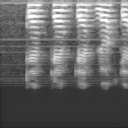

'Latent space noise'

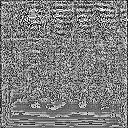

'Reconstructed'

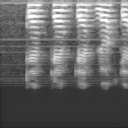

'Original - Reconstructed'

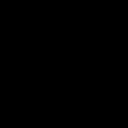

In [106]:
show_reconstructions(Path("../data/inversion/guided_diffusion/yes_no/250 steps/"), mel_yes_no, 3)

# YesNo - 50 ddim steps

(128, 128, 3)


'MSE reconstruction 119.81915283203125'

'Original'

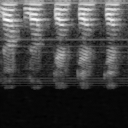

'Latent space noise'

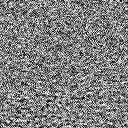

'Reconstructed'

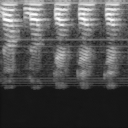

'Original - Reconstructed'

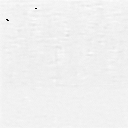

In [107]:
show_reconstructions(Path("../data/inversion/guided_diffusion/yes_no/50 steps/"), mel_yes_no, 3)

# Maestro

(256, 256, 1)


'MSE reconstruction 75.38003540039062'

'Original'

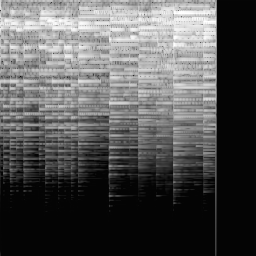

'Latent space noise'

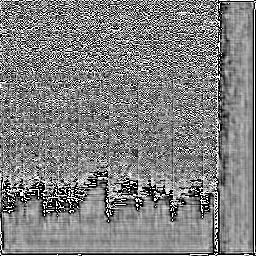

'Reconstructed'

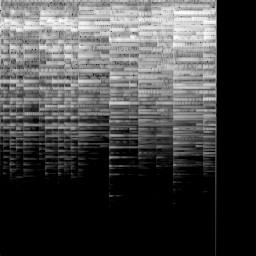

'Original - Reconstructed'

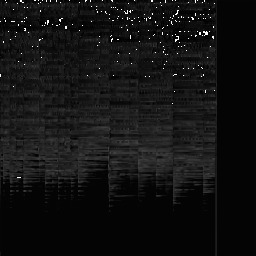

In [108]:
show_reconstructions(Path("../data/inversion/guided_diffusion/maestro/1000 steps/"), mel_maestro, 1)

'Original'

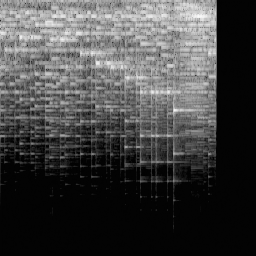

In [117]:
show_reconstructions(Path("../nice audios/"), mel_maestro, 1, original_only=True, original_filename="nice_1.npy")

# Plot corruptions

In [9]:
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('dark_background')
[width, height] = matplotlib.rcParams['figure.figsize']
if width < 10:
  matplotlib.rcParams['figure.figsize'] = [width * 2.5, height]

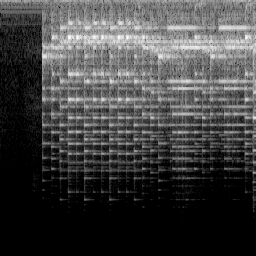

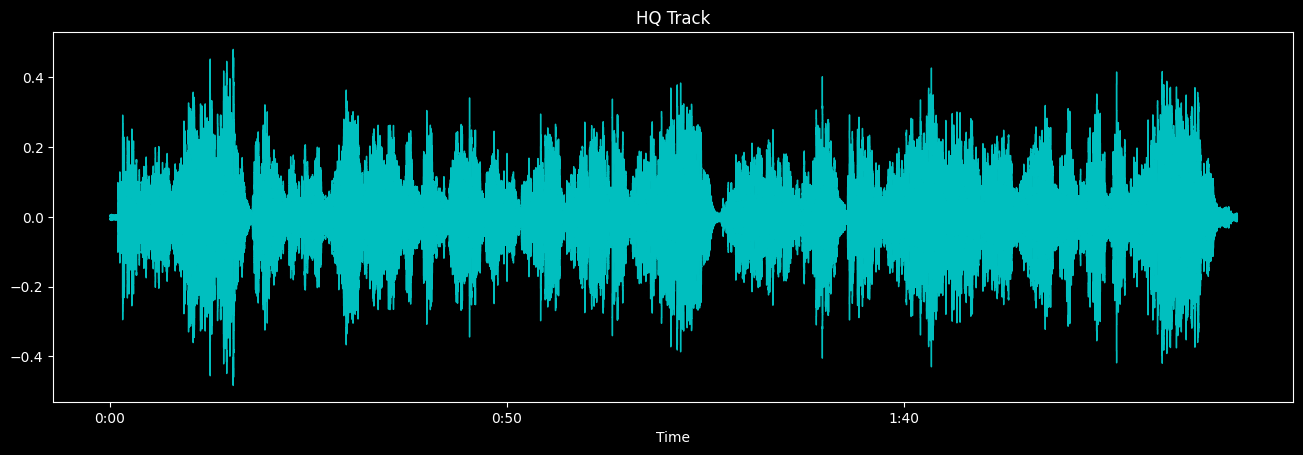

In [13]:
import torchaudio
from clearaudio.viz import plots

waveform, sr = torchaudio.load(r"/home/martorel/dev/clearaudio/samples/hq/sample1.wav")

mel_maestro.load_audio(raw_audio=waveform.numpy()[0])

display(mel_maestro.audio_slice_to_image(0))
display(Audio(data=mel_maestro.get_audio_slice(0), rate=mel_maestro.get_sample_rate()))
plots.plot_waveform(waveform, sr, title="HQ Track", color='c');

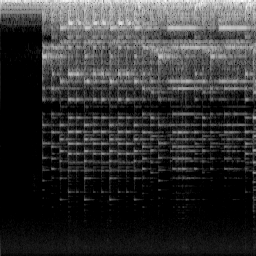

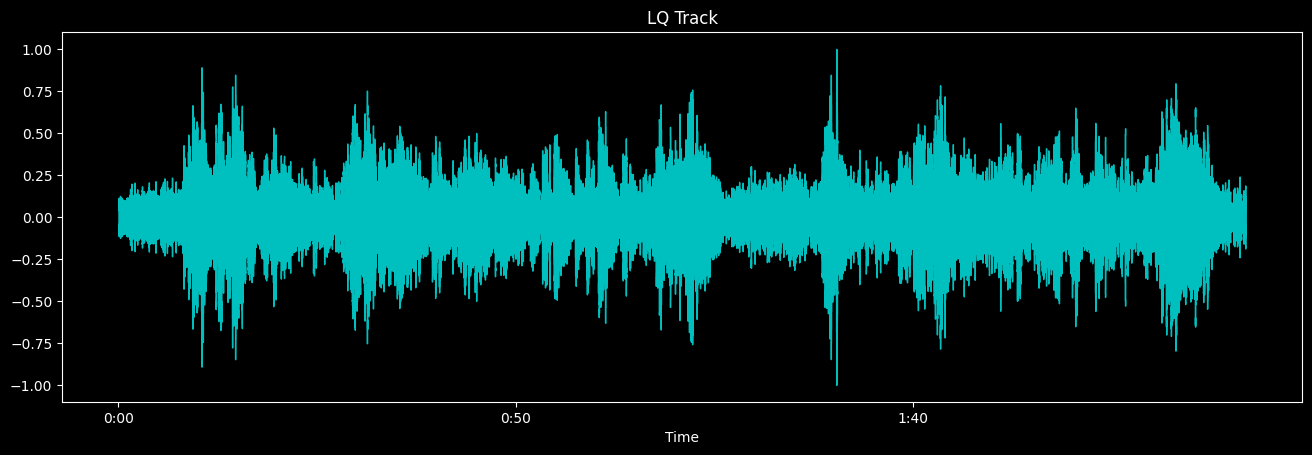

In [30]:
from clearaudio.transforms import signal
import torch

sox = signal.SoxEffectTransform()
sox.add_equalizer(600, -50, 5)
sox.add_equalizer(2000, -50, 1)
sox.add_equalizer(8000, -10, 0.7)
sox.normalize_gain()

eq, sr = sox.apply_tensor(waveform, sr)
mel_maestro.load_audio(raw_audio=eq.numpy()[0])
display(mel_maestro.audio_slice_to_image(0))
display(Audio(data=mel_maestro.get_audio_slice(0), rate=mel_maestro.get_sample_rate()))
plots.plot_waveform(eq, sr, title="LQ Track", color='c');

<AxesSubplot:title={'center':'Compaison HQ / LQ'}, xlabel='Time (ms)'>

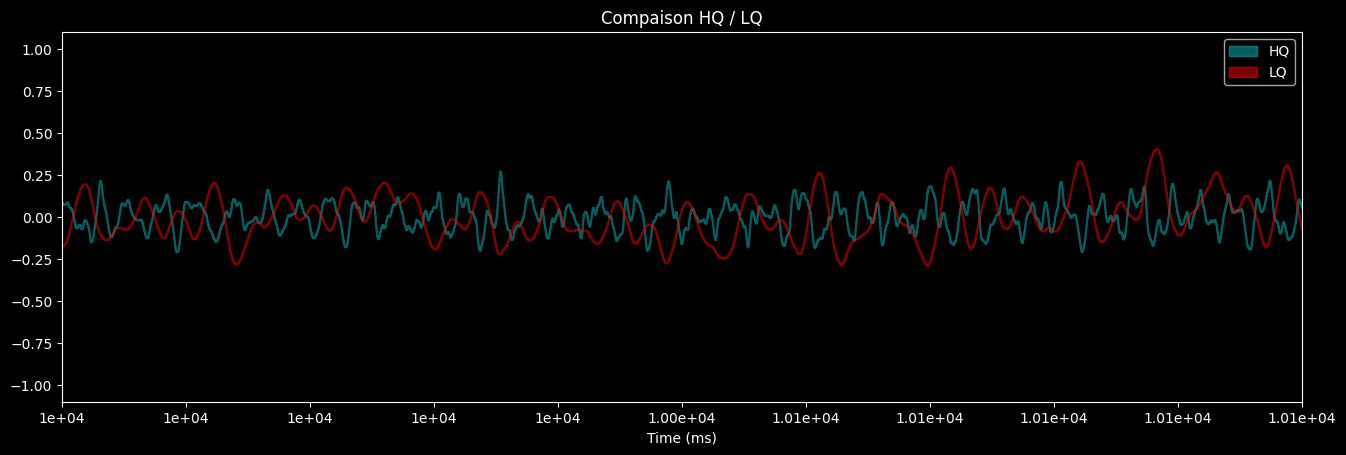

In [28]:
plots.compare_waveforms(waveform, sr, eq, 
    title='Compaison HQ / LQ', 
    label_left='HQ', 
    label_right='LQ',
    xlim=[10, 10.1], x_axis='ms')